In [1]:
'''
    Importing libraries
    ___________________

    numpy for easier matrix operations
    -----------------
    numba->jit to make numpy faster
    -----------------
    Pillow->Image to open an image
    -----------------
    os for folder process 
    -----------------
    matplotlib->pyplot to plot tables, images, etc.
    -----------------
    MatplotlibToolkits->mplot3d->Axes3D to plot 3d tables
    -----------------
    Scikit-learn->cluster->KMeans to apply clustering
    -----------------
    Scikit-learn->metrics to calculate important scores
'''
import numpy as np
from numba import jit
from PIL import Image
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Part 1

In [2]:
class PCA:
    '''
        Parameters
        ______________
        
        n_components : int
            This value indicates that the reduced dimension of a vector.
    '''
    def __init__(self, n_components: int) -> None:
        
        self.n_components = n_components

    def fit_transform(self, x: np.array) -> np.array:
        # mean centering
        mean = np.mean(x, axis=0).reshape(-1, 1).T

        D = x - mean

        # covariance matrix calculation and normalization : (x.shape[1], x.shape[1])
        cov = (D.T @ D) / (D.shape[0] - 1)

        # eigenvectors, eigenvalues : (x.shape[1], x.shape[1]), (x.shape[1],)
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[:,idxs]

        # (x.shape[1], x.shape[1]) -> (x.shape[1], n_components)
        components = eigenvectors[:, :self.n_components]

        # (x.shape[1], x.shape[0]) @ (x.shape) @ (x.shape[1], n_components) -> 
        # (x.shape[1], x.shape[0]) @ (x.shape[0], n_components) -> 
        # (x.shape[1], n_components) -> (n_components, x.shape[1])
        return (x.T @ (D @ components)).T

In [3]:
'''
    Reading Part 1 images
'''
# listing image paths in Dataset1
paths = os.listdir(path='dataset/Dataset1')

# reading images
part1_imgs = np.array([np.array(Image.open("./dataset/Dataset1/" + path)) for path in paths])

# reshaping images
part1_imgs = part1_imgs.reshape(11, -1)
part1_imgs.shape

(11, 65536)

In [4]:
'''
    Applying PCA
'''
pca = PCA(3)
pca_applied = pca.fit_transform(part1_imgs.T)
pca_applied.shape

(3, 11)

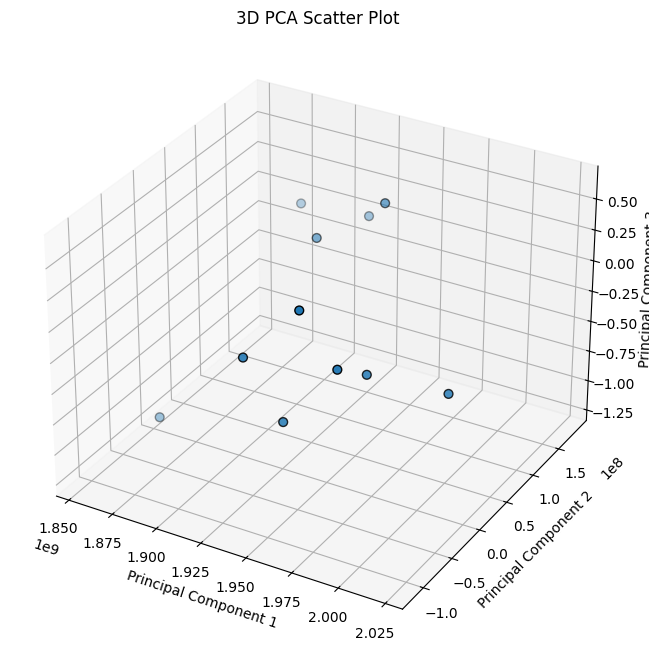

In [5]:
'''
    Plotting this PCA results in 3D format
'''

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_applied[0, :], pca_applied[1, :], pca_applied[2, :], edgecolor='k', s=40)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA Scatter Plot')
plt.show()


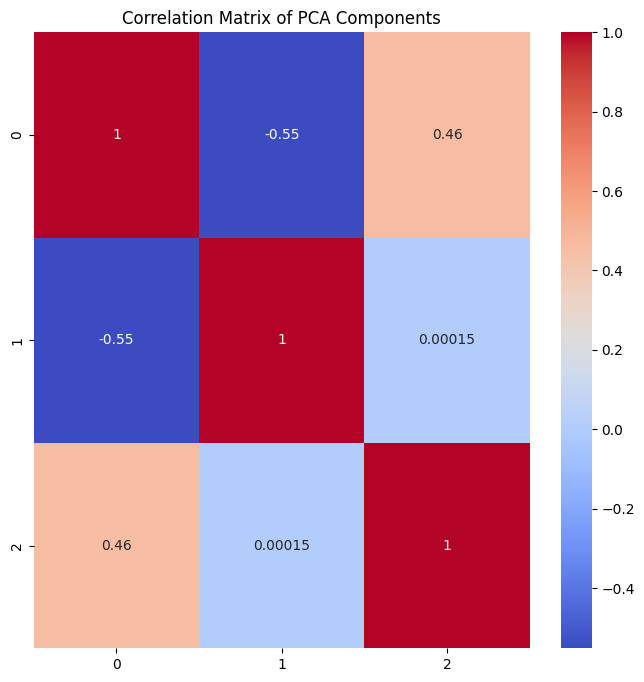

In [6]:
corr_matrix = np.corrcoef(pca_applied)

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of PCA Components')
plt.show()

- As we can see on the correlation map, the features are not correlated with each other well, that means our PCA extracted features different from each other as possible.

# Part 2

In [7]:
@jit(nopython=True) # Accelerating with numba
def get_pca_features(imgs: np.array, n_components: int =3):
    '''
        Definition
        ___________
        A feature extracter using pca for an image matrix
    
        Parameters
        ___________
        imgs : np.array
            An image matrix shaped (n_images, n_features)

        n_components : int
            how many features do images need. 
        
        Returns
        ___________
        features : np.array
            extracted PCA features shaped (n_components, n_images)

    '''
    # defining PCA
    pca = PCA(n_components=n_components)

    # applying PCA to get features
    features = pca.fit_transform(imgs.T)

    # returning features
    return features

In [8]:
@jit(nopython=True) # accelerating with numba
def get_hist_features(img, n_bins=256):
    '''
        Definition
        _____________
        A function to get a Color Histogram for an image

        Parameters
        _____________
        img : np.array
            An image shaped (height, width, channels)

        n_bins : int
            how many bins will be in the histogram

        Returns
        ____________
        hist : np.array
            A color histogram shaped (n_bins**3)
    '''
    
    height, width, channels = img.shape
    
    # defining an empty histogram
    hist = np.zeros((n_bins, channels))

    for h in range(height):
        for w in range(width):

            # Red, Green, Blue values
            r, g, b = img[h, w]

            # decide the bin coordinates
            r = int(r * n_bins / 256)
            g = int(g * n_bins / 256)
            b = int(b * n_bins / 256)

            # adding one to that bin
            hist[r, 0] += 1
            hist[g, 1] += 1
            hist[b, 2] += 1
    # Flatten color histogram
    hist = hist.flatten()

    # normalize color histogram
    hist /= (width * height)
    return hist

In [9]:
# Reading Part 2 images

# renaming googse to goose as it spelled wrong.
# os.rename('Dataset2/googse/', 'Dataset2/goose/')

# listing classes in Dataset2 Directory and removing QUERY_IMAGES because its shape is different and it should not be used in training
data_path = 'dataset/Dataset2'
classes = os.listdir(path=data_path)
classes.remove('QUERY_IMAGES')

# listing image paths, and adding numerical labels to them.
img_paths = [f'{data_path}/{cls}/{path}' for cls in classes for path in os.listdir(path=f'{data_path}/{cls}')]
labels = np.array([classes.index(cls) for cls in classes for _ in os.listdir(path=f'{data_path}/{cls}')])

# listing query image paths and labels
query_paths = [f'{data_path}/QUERY_IMAGES/{path}' for path in os.listdir(path=f'{data_path}/QUERY_IMAGES')]
query_labels = np.array([classes.index(path.split('_')[0]) for path in os.listdir(path=f'{data_path}/QUERY_IMAGES')])
sorted_query_indices = np.argsort(query_labels)

# Reading images using Pillow Image and then converting them into np.array
imgs = []
for path in img_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((256, 256))
    img = np.array(img)
    imgs.append(img)
imgs = np.array(imgs)

query_imgs = []
for path in query_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((256, 256))
    img = np.array(img)
    query_imgs.append(img)
query_imgs = np.array(query_imgs)
query_imgs = query_imgs[sorted_query_indices]
query_labels = query_labels[sorted_query_indices]

In [10]:
# extracting histogram features
hists = []
for img in imgs:
    hist = get_hist_features(img, )
    hists.append(hist)
hists = np.array(hists)

query_hists = []
for img in query_imgs:
    hist = get_hist_features(img)
    query_hists.append(hist)
query_hists = np.array(query_hists)

In [11]:
# applying PCA and reducing dimensionality
flattened_imgs = imgs.reshape(imgs.shape[0], -1)
flattened_query_imgs = query_imgs.reshape(query_imgs.shape[0], -1)
pca = PCA(15)
components = pca.fit_transform(flattened_imgs.T).T
query_components = pca.fit_transform(flattened_query_imgs.T).T

### Create Ranked Matrices

In [12]:
@jit(nopython=True)
def euclidian_distance(x1: np.array, x2: np.array):
    '''
        Definition
        _____________
        calculates and returns euclidean distance between to Matrix

        Parameters
        _____________
        x1, x2: np.array
            matrices that will be calculated dissimilarities

        Returns
        _____________
        Euclidean Distance of x1 and x2
    '''
    return np.sqrt(np.sum((x1 - x2)**2))

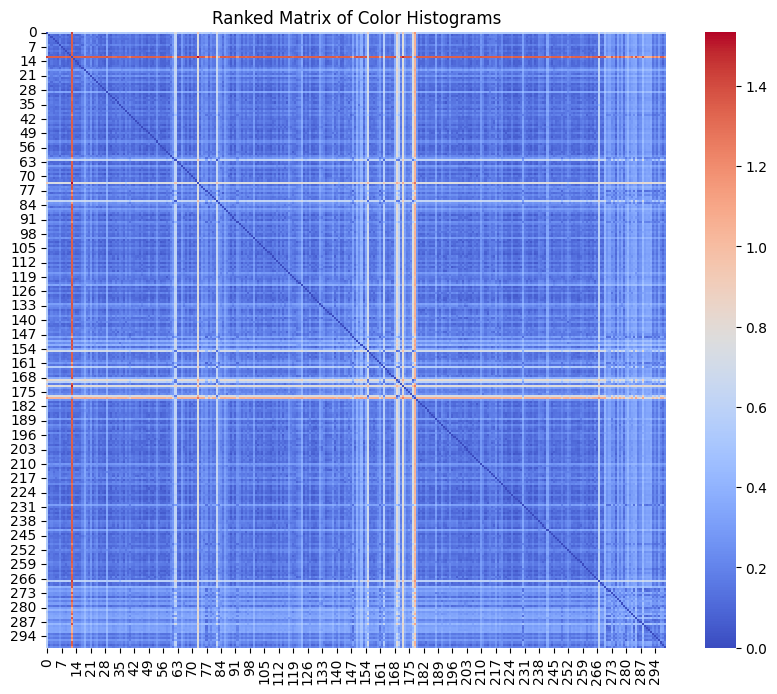

In [13]:
# Creating a Ranked Matrix for Histogram Training Features
ranked_matrix_hist = np.array([[euclidian_distance(hist1, hist2) for hist2 in hists] for hist1 in hists])

plt.figure(figsize=(10, 8))
sns.heatmap(ranked_matrix_hist, annot=False, cmap='coolwarm')
plt.title('Ranked Matrix of Color Histograms')
plt.show()

- Seems Like most of the histogram features doesn't have lots of difference, most of them have difference between 0.2 to 0.5

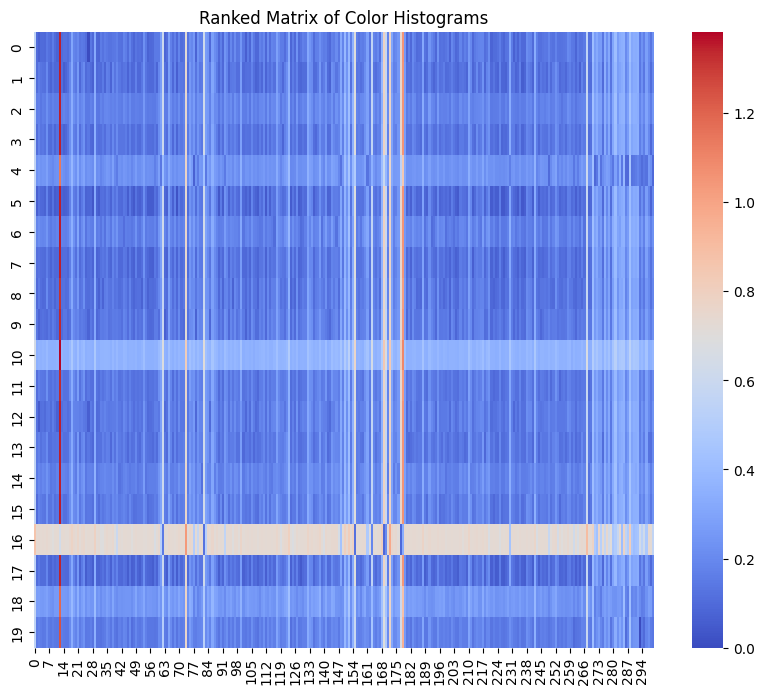

In [14]:
# Creating a Ranked Matrix for Histogram Query Features
ranked_matrix_hist_query = np.array([[euclidian_distance(hist1, hist2) for hist2 in hists] for hist1 in query_hists])

plt.figure(figsize=(10, 8))
sns.heatmap(ranked_matrix_hist_query, annot=False, cmap='coolwarm')
plt.title('Ranked Matrix of Color Histograms')
plt.show()

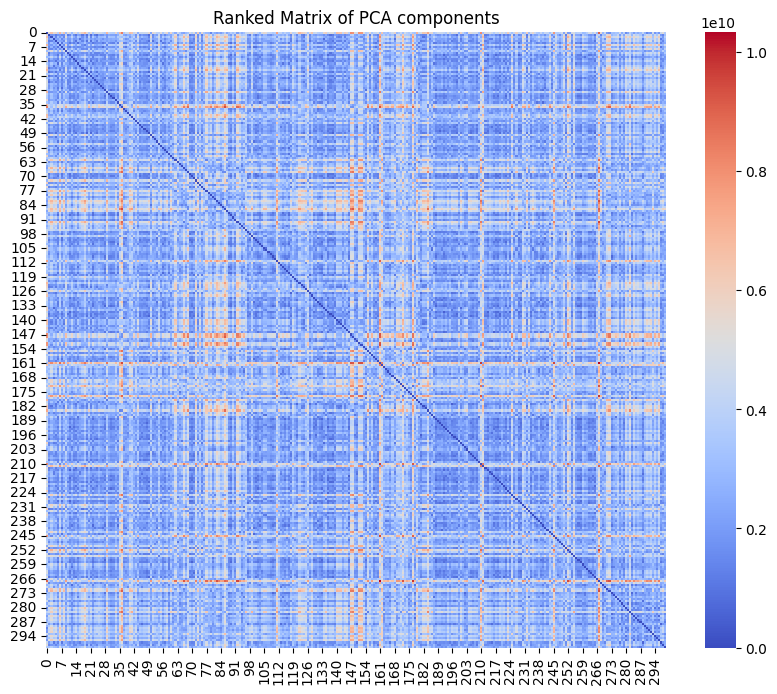

In [15]:
# Creating a Ranked Matrix for PCA Training Features
ranked_matrix_pca  = np.array([[euclidian_distance(c1, c2) for c2 in components] for c1 in components])

plt.figure(figsize=(10, 8))
sns.heatmap(ranked_matrix_pca, annot=False, cmap='coolwarm')
plt.title('Ranked Matrix of PCA components')
plt.show()

- Seems Like most of the PCA features doesn't have lots of difference, most of them have difference between 0 and 0.4.

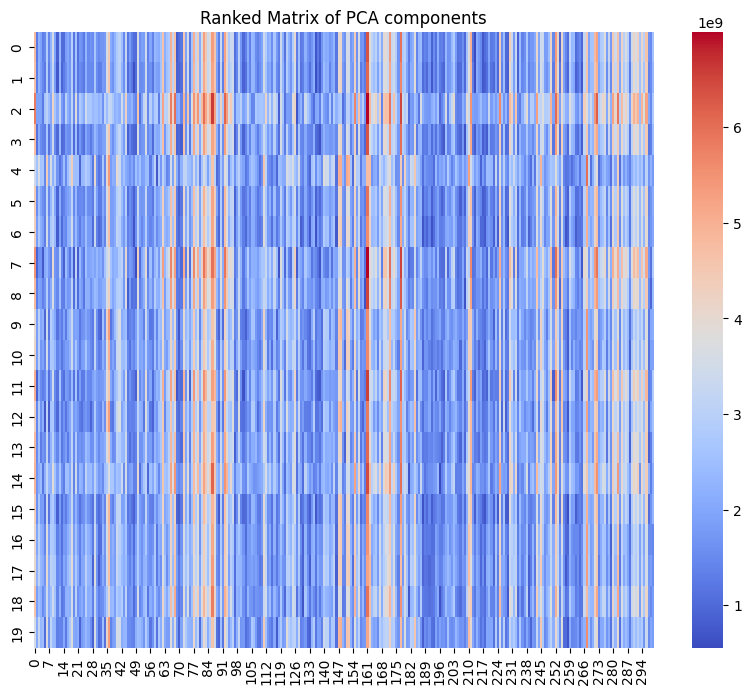

In [16]:
# Creating a Ranked Matrix for PCA Query Features
ranked_matrix_pca_query = np.array([[euclidian_distance(c1, c2) for c2 in components] for c1 in query_components])

plt.figure(figsize=(10, 8))
sns.heatmap(ranked_matrix_pca_query, annot=False, cmap='coolwarm')
plt.title('Ranked Matrix of PCA components')
plt.show()

### Cluster QUERY IMAGES using K-Means

In [17]:
# Applying K-Means clustering to Histogram Features
n_clusters = 10
k_means_hist = KMeans(n_clusters=n_clusters, random_state=42)
k_means_hist.fit(hists)
cluster_labels_hist = k_means_hist.predict(hists)
cluster_labels_hist

/home/grkmkola/miniconda3/envs/cv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 3, 5, 5, 5, 3, 5, 3, 3, 1, 3, 3, 2, 5, 3, 3, 3, 5, 5, 3, 1, 5,
       3, 5, 5, 3, 5, 3, 3, 5, 3, 3, 6, 3, 6, 3, 5, 6, 5, 3, 5, 1, 1, 6,
       6, 3, 1, 3, 3, 3, 1, 3, 5, 3, 1, 3, 3, 3, 3, 6, 5, 4, 8, 5, 3, 1,
       1, 3, 1, 3, 3, 5, 5, 0, 1, 5, 3, 4, 5, 4, 6, 1, 8, 4, 1, 5, 5, 1,
       3, 3, 1, 3, 4, 1, 3, 3, 3, 6, 3, 3, 5, 6, 5, 3, 3, 6, 3, 3, 3, 6,
       3, 1, 3, 6, 3, 1, 6, 1, 1, 3, 3, 5, 5, 5, 3, 3, 3, 6, 3, 3, 6, 3,
       1, 1, 3, 3, 3, 3, 3, 1, 3, 5, 3, 3, 5, 5, 6, 5, 4, 1, 1, 5, 5, 1,
       1, 8, 1, 5, 6, 3, 5, 4, 1, 8, 6, 6, 6, 5, 3, 8, 8, 1, 7, 1, 1, 3,
       1, 8, 2, 1, 3, 3, 3, 3, 5, 3, 3, 3, 6, 6, 3, 6, 6, 6, 3, 6, 3, 3,
       3, 1, 6, 5, 1, 6, 3, 3, 6, 3, 3, 6, 5, 1, 3, 3, 5, 6, 6, 5, 3, 5,
       3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 4, 3, 5, 3, 3, 3, 3, 3, 1, 1, 6, 3,
       1, 3, 3, 5, 3, 3, 3, 4, 3, 3, 5, 5, 3, 3, 1, 6, 6, 3, 3, 3, 3, 1,
       3, 5, 6, 9, 3, 3, 6, 4, 4, 6, 4, 3, 4, 6, 1, 3, 4, 4, 4, 6, 4, 1,
       4, 4, 6, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 4], d

In [18]:
unique_elements_hist, counts_hist = np.unique(cluster_labels_hist, return_counts=True)
unique_elements_hist, counts_hist

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([  1,  45,   2, 126,  26,  50,  41,   1,   7,   1]))

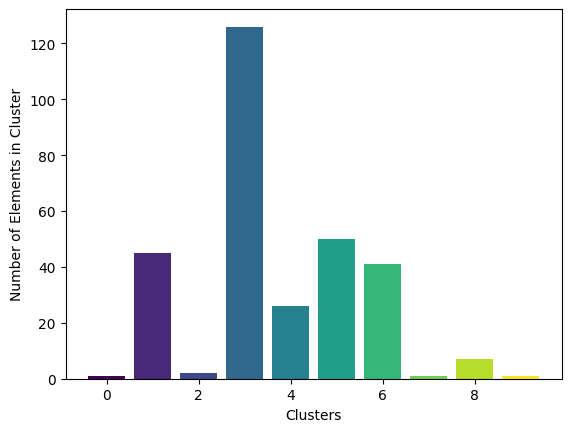

In [19]:
x = np.arange(10)
# Create a color array
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Create the histogram
plt.bar(x, counts_hist, color=colors)

# Set the labels
plt.xlabel('Clusters')
plt.ylabel('Number of Elements in Cluster')

plt.show()


In [20]:
cluster_query_labels_hist = k_means_hist.predict(query_hists)
cluster_query_labels_hist

array([5, 3, 3, 3, 4, 3, 6, 3, 3, 5, 3, 3, 5, 3, 1, 3, 8, 3, 4, 3],
      dtype=int32)

In [21]:
unique_elements_hist_query, counts_hist_query = np.unique(cluster_query_labels_hist, return_counts=True)
unique_elements_hist_query, counts_hist_query

(array([1, 3, 4, 5, 6, 8], dtype=int32), array([ 1, 12,  2,  3,  1,  1]))

- Many of them turned out to be the same class 3, because they do not have lots of difference as we saw in Ranked List heatmap

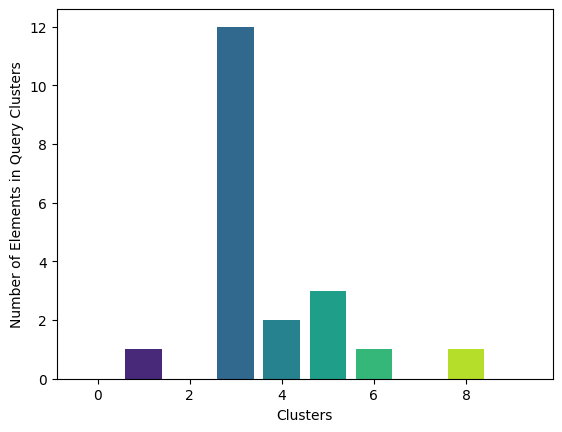

In [22]:
x = np.arange(10)
y = np.zeros(10)
y[unique_elements_hist_query] = counts_hist_query
# Create a color array
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Create the histogram
plt.bar(x, y, color=colors)

# Set the labels
plt.xlabel('Clusters')
plt.ylabel('Number of Elements in Query Clusters')

plt.show()

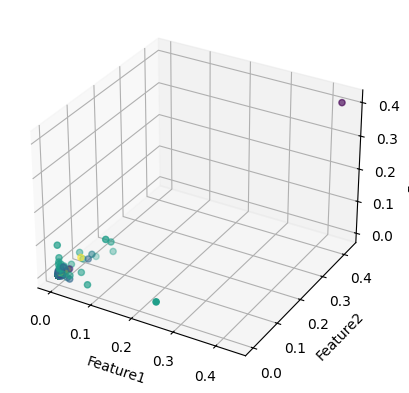

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hists[:,0], hists[:, 1], hists[:, 2], c=cluster_labels_hist)

ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')

plt.show()

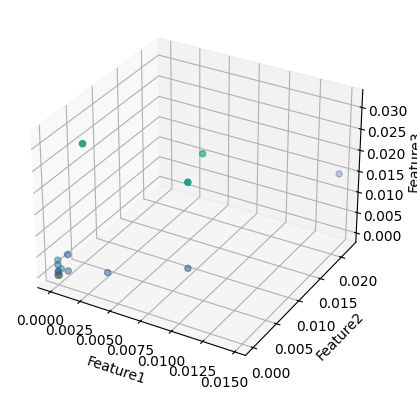

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(query_hists[:,0], query_hists[:, 1], query_hists[:, 2], c=cluster_query_labels_hist)

ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')

plt.show()

In [25]:
k_means_pca = KMeans(n_clusters=n_clusters, random_state=42)
k_means_pca.fit(components)
cluster_labels_pca = k_means_pca.predict(components)
cluster_labels_pca

/home/grkmkola/miniconda3/envs/cv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([6, 8, 0, 5, 8, 1, 0, 7, 0, 2, 7, 1, 2, 8, 8, 1, 5, 0, 0, 8, 3, 8,
       1, 7, 8, 7, 7, 7, 1, 0, 1, 1, 1, 8, 1, 9, 4, 1, 7, 5, 0, 9, 3, 8,
       2, 8, 5, 8, 8, 8, 2, 8, 8, 7, 2, 8, 1, 7, 7, 2, 9, 2, 6, 7, 2, 2,
       6, 2, 3, 8, 1, 8, 6, 0, 3, 8, 1, 6, 3, 6, 1, 3, 6, 6, 2, 3, 3, 6,
       1, 1, 3, 1, 6, 3, 2, 3, 9, 8, 7, 9, 7, 8, 1, 1, 8, 9, 9, 1, 1, 1,
       1, 4, 7, 5, 1, 1, 2, 1, 8, 2, 1, 8, 9, 0, 0, 7, 2, 8, 9, 1, 8, 7,
       1, 1, 5, 9, 1, 7, 8, 1, 0, 0, 0, 7, 0, 7, 1, 4, 4, 9, 5, 4, 0, 8,
       1, 3, 7, 3, 1, 7, 8, 6, 7, 2, 3, 3, 5, 3, 5, 2, 2, 3, 6, 5, 3, 2,
       5, 6, 2, 0, 7, 8, 0, 0, 4, 7, 9, 3, 1, 8, 8, 5, 1, 1, 8, 5, 8, 8,
       8, 1, 8, 7, 2, 3, 8, 8, 8, 8, 8, 3, 0, 6, 8, 8, 5, 5, 1, 8, 1, 8,
       1, 8, 1, 0, 1, 3, 7, 9, 7, 8, 6, 3, 0, 3, 8, 9, 1, 1, 3, 1, 1, 7,
       5, 3, 7, 0, 2, 1, 7, 1, 6, 8, 6, 6, 8, 9, 1, 1, 1, 2, 2, 1, 8, 8,
       1, 8, 3, 4, 7, 2, 5, 6, 6, 2, 2, 3, 2, 5, 2, 1, 6, 2, 3, 2, 6, 2,
       2, 2, 5, 2, 6, 2, 6, 9, 6, 2, 6, 5, 8, 2], d

In [26]:
unique_elements_pca, counts_pca = np.unique(cluster_labels_pca, return_counts=True)
unique_elements_pca, counts_pca

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([22, 56, 38, 29,  7, 20, 26, 31, 55, 16]))

In [27]:
cluster_query_labels_pca = k_means_pca.predict(query_components)
cluster_query_labels_pca

array([8, 8, 8, 8, 1, 8, 1, 8, 8, 1, 5, 8, 7, 5, 8, 1, 1, 1, 8, 1],
      dtype=int32)

In [28]:
unique_elements_pca_query, counts_pca_query = np.unique(cluster_query_labels_pca, return_counts=True)
unique_elements_pca_query, counts_pca_query

(array([1, 5, 7, 8], dtype=int32), array([ 7,  2,  1, 10]))

- We can see that pca clusters are more equally seperated than hists, there can be several reasons behind it
    - PCA extract more robust features than color histogram
    - Color Histogram gives (768, ) dimensional feature vectors for each image and PCA gives (15, ) dimensional feature vectors, so maybe Color Histogram may have been subjected to the curse of dimensionality.

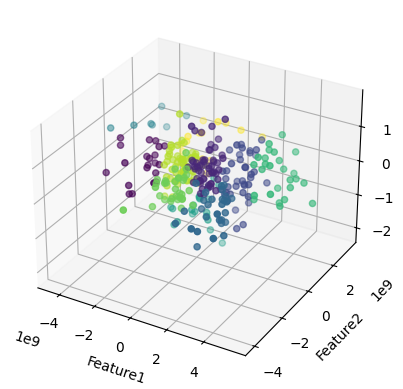

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(components[:,0], components[:, 1], components[:, 2], c=cluster_labels_pca)

ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')

plt.show()

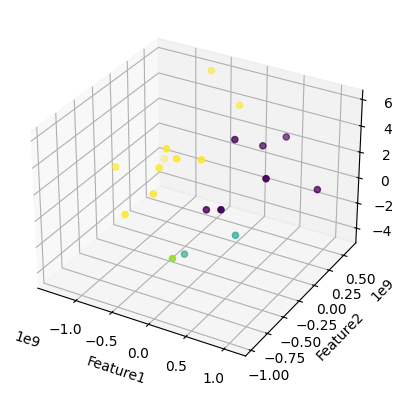

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(query_components[:,0], query_components[:, 1], query_components[:, 2], c=cluster_query_labels_pca)

ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')

plt.show()

### Mean Average Precision

In [31]:
def calculate_precision(ranked_list: np.array, label: int, labels: np.array, curr: int, train: bool=False):
    '''
        Definition
        ____________
        This function calculates precision for a ranked list

        Parameters
        ____________
        ranked_list : np.array
            Given Ranked List
        
        label : int
            The label of the query

        labels : np.array
            Labels of the Ranked List
        
        curr : int
            current position of query, (if train is positive to delete the image from ranked list)

        train : bool
            shows if training images are calculated

        Attributes
        ___________
        sorted_idxs : np.array
            Sorted Indices of Ranked List to sort labels.
        
        relevant_imgs : int
            shows how many relevant image is occured

        precision : List[int] -> np.array
            Precisions values

        Returns
        _________
        Mean of Precision values if there is not anything then 0
    '''
    if train:
        labels = np.delete(labels, curr)
        ranked_list = np.delete(ranked_list, curr)
    sorted_idxs = np.argsort(ranked_list)
    labels = labels[sorted_idxs]
    relevant_imgs = 0
    precision = []
    
    for i, lbl in enumerate(labels):
        if lbl == label:
            relevant_imgs += 1
            precision.append(relevant_imgs / (i+1))

    precision = np.array(precision)
    return np.mean(precision) if precision.size != 0 else 0

def calculate_map(ranked_matrix: np.array, label: int, labels: np.array, curr: int, train: bool):
    '''
        Definition
        ____________
        This function calculates Mean Average Precision for a Ranked Matrix

        Parameters
        ____________
        ranked_matrix : np.array
            Given Ranked Matrix that contains Ranked Lists in it
        
        label : int
            The label of the query

        labels : np.array
            Labels of the Ranked List
        
        curr : int
            current position of query, (if train is positive to delete the image from ranked list)

        train : bool
            shows if training images are calculated

        Returns
        _________
        map : int
            Mean of Average Precision values
    '''
    map = np.array([calculate_precision(ranked_list, label, labels, curr+i, train=train) for i, ranked_list in enumerate(ranked_matrix)])
    return np.mean(map)

In [32]:
# Train Histogram mAP
hist_map = {classes[i//30]:calculate_map(ranked_matrix_hist[i:i+30], labels[i], labels, i, train=True) for i in range(0, len(ranked_matrix_hist), 30)}
hist_map

{'iris': 0.16870490908538016,
 'goat': 0.1845192140425534,
 'bonsai': 0.10654155327972098,
 'bear': 0.12056128932976866,
 'ibis': 0.10053289514319007,
 'blimp': 0.10387115890119888,
 'goose': 0.14851601943681153,
 'cactus': 0.1576631294840979,
 'dog': 0.14379483256668152,
 'airplane': 0.30947487451858235}

In [33]:
# Query Histogram mAP
hist_query_map = {classes[i//2]: calculate_map(ranked_matrix_hist_query[i:i+2], query_labels[i], labels, i, train=False) for i in range(0, len(ranked_matrix_hist_query), 2)}
hist_query_map

{'iris': 0.19196109211422935,
 'goat': 0.16368637777269096,
 'bonsai': 0.1279520551596584,
 'bear': 0.12236915322964481,
 'ibis': 0.09805158709964386,
 'blimp': 0.06508786931787386,
 'goose': 0.15038857494861485,
 'cactus': 0.16231570028082565,
 'dog': 0.12866630956373046,
 'airplane': 0.2971504309461797}

In [34]:
# Mean and Standard Deviation of Histogram mAP values
np.mean(list(hist_map.values())), np.std(list(hist_map.values())), np.mean(list(hist_query_map.values())), np.std(list(hist_query_map.values()))

(0.15441798757879854,
 0.05848766348405178,
 0.15076291504330916,
 0.05946487706055678)

In [35]:
# Train PCA mAP
pca_map = {classes[i//30]: calculate_map(ranked_matrix_pca[i:i+30], labels[i], labels, i, train=True) for i in range(0, len(ranked_matrix_pca), 30)}
pca_map

{'iris': 0.1875446231981099,
 'goat': 0.11535830768108839,
 'bonsai': 0.16731167169631492,
 'bear': 0.1267335437671261,
 'ibis': 0.16195162000610422,
 'blimp': 0.11467681499838468,
 'goose': 0.15235368228753635,
 'cactus': 0.13684789063860262,
 'dog': 0.11362608116712485,
 'airplane': 0.28929401184791276}

In [36]:
# Query PCA mAP
pca_query_map = {classes[i//2]: calculate_map(ranked_matrix_pca_query[i:i+2], query_labels[i], labels, i, train=False) for i in range(0, len(ranked_matrix_pca_query), 2)}
pca_query_map

{'iris': 0.13809721064865255,
 'goat': 0.11607096258745134,
 'bonsai': 0.09144041269715042,
 'bear': 0.10864014474090676,
 'ibis': 0.11544780015799298,
 'blimp': 0.07767738250714692,
 'goose': 0.16569600655663946,
 'cactus': 0.175171447968673,
 'dog': 0.14021311098533185,
 'airplane': 0.08091425411729349}

In [37]:
# Mean and Standard Deviation of Histogram mAP values
np.mean(list(pca_map.values())), np.std(list(pca_map.values())), np.mean(list(pca_query_map.values())), np.std(list(pca_query_map.values()))

(0.15656982472883046,
 0.0503130318098884,
 0.1209368732967239,
 0.03187329750570469)

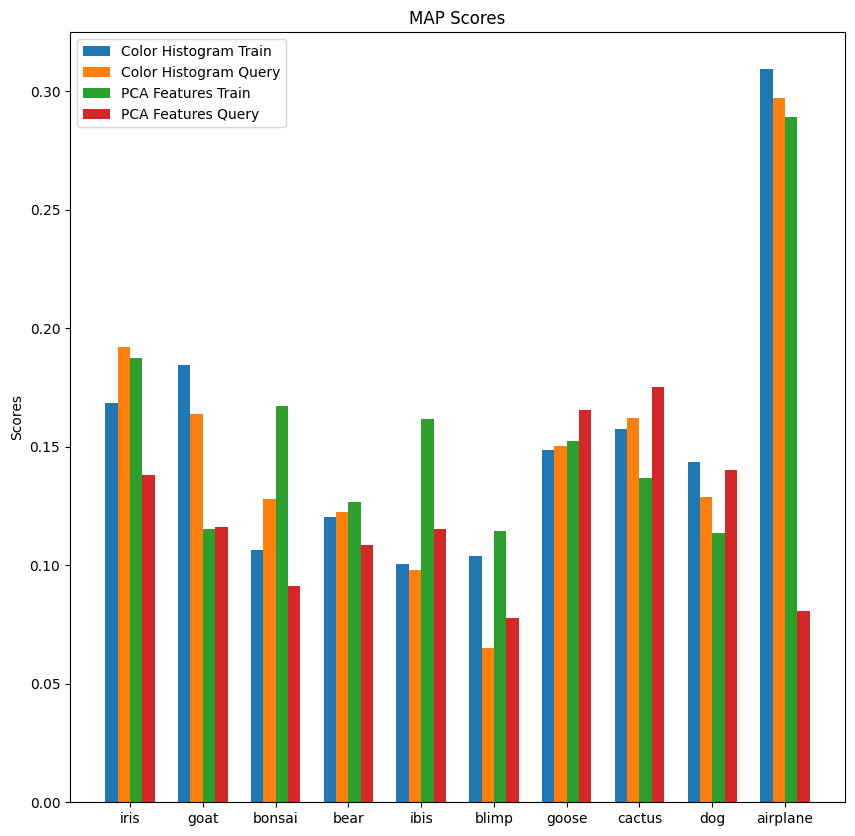

In [38]:
# Create a figure and a set of subplots
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

# Number of bars
N = len(classes)

# Arrange the data
ind = np.arange(N)

# Width of the bars
width = 0.17

# Plotting
p1 = ax.bar(ind, hist_map.values(), width, bottom=0)
p2 = ax.bar(ind + width, hist_query_map.values(), width, bottom=0)
p3 = ax.bar(ind + width * 2, pca_map.values(), width, bottom=0)
p4 = ax.bar(ind + width * 3, pca_query_map.values(), width, bottom=0)

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Scores')
ax.set_title('MAP Scores')
ax.set_xticks(ind + width * 3 / 2)
ax.set_xticklabels(classes)

ax.legend((p1[0], p2[0], p3[0], p4[0]), ('Color Histogram Train', 'Color Histogram Query', 'PCA Features Train', 'PCA Features Query'))
ax.autoscale_view()

plt.show()

# Part 3

In [39]:
@jit(nopython=True)
def sigmoid(z: np.array) -> np.array:
    '''
        Definition
        __________
        Sigmoid function
    '''
    return 1 / (1 + np.exp(-z))

In [40]:
@jit(nopython=True)
def get_cost(X: np.array, y: np.array, theta: np.array) -> float:
    '''
        Definition
        __________
        This function calculates and returns Logistic Loss between predicted and original labels
        
        Parameters
        __________
        X : np.array
            Input of a model

        y : np.array
            original labels

        theta : np.array
            Weight matrix that will be multiplied by

        Attributes
        __________
        eps: float
            An epsilon value to ensure np.log(0) case not happened
        Returns
        _________
        A float that shows the cost
        
        Formula
        _________
        Summation (y * log(y') - (1-y) * log(1-y'))
    '''
    h = sigmoid(X @ theta)
    eps = 1e-5
    cost = 1 / len(y) * np.sum(-y * np.log(h + eps) - (1-y) * np.log(1 - h + eps))
    return cost

In [41]:
@jit(nopython=True)
def gradient_descent(X, y, theta, alpha, n_iterations):
    '''
        Definition
        __________
        This function applies gradient descent to theta

        Parameters
        __________
        X : np.array
            Input of a model

        y : np.array
            original labels

        theta : np.array
            Weight matrix that will be multiplied by

        alpha : float
            Learning Rate

        n_iterations : int
            number of iterations

        Attributes
        __________
        lenght : int
            lenght of labels

        Returns
        ___________
        cost_history : List[float]
            A list that contains costs for each iteration
        
        theta : np.array
            Weight matrix applied gradient descent
    '''
    # Defining Length
    lenght = len(y)

    # Initializing Cost History List
    cost_history = []

    for _ in range(n_iterations):
        # Updating Weights
        theta -= (1 / lenght * alpha) * (X.T @ (sigmoid(X @ theta) - y))
        
        # Getting cost and adding to Cost History List
        cost = get_cost(X, y, theta)
        cost_history.append(cost)

    return cost_history, theta

In [42]:
@jit(nopython=True)
def predict(X, theta):
    '''
        Definition
        ___________
        Prediction Function

        Parameters
        ___________
        X : np.array
            Input of a model

        theta : np.array
            Weight matrix that will be multiplied by

        Returns
        ____________
        A numerical class label
    '''
    return np.round(sigmoid(X @ theta))

In [43]:
def train(imgs: np.array, labels: np.array, classes: list[int|str]):
    '''
        Definition
        ___________
        MultiClass Logistic Regression Training Code

        Parameters
        ___________
        imgs : np.array
            Image matrix
        
        labels : np.array
            Labels of images

        classes : list[int|str]
            Classes to get length

        Attributes
        ___________
        learning_rate : float
            Learning Rate to apply in gradient descent

        iterations : int
            Number of iterations will be applied

        Returns
        __________
        cost_histories : np.array
            Cost Histories for each one-vs-all

        thetas : np.array
            Weights for each one-vs-all
    '''
    learning_rate = 0.1
    iterations = 20_000
    thetas = np.zeros((len(classes), imgs.shape[1]))
    cost_histories = np.zeros((len(classes), iterations))
    for c in range(len(classes)):
        y = (labels == c).astype(int).reshape(-1, 1)
        theta_c = np.random.rand(imgs.shape[1], 1)
        cost_histories[c], theta_c = gradient_descent(imgs, y, theta_c, learning_rate, iterations)
        thetas[c] = theta_c.flatten()
    return cost_histories, thetas

In [44]:
def train_binary(imgs, labels):
    '''
        Definition
        ___________
        Binary Logistic Regression Training Code

        Parameters
        ___________
        imgs : np.array
            Image matrix
        
        labels : np.array
            Labels of images

        Attributes
        ___________
        learning_rate : float
            Learning Rate to apply in gradient descent

        iterations : int
            Number of iterations will be applied

        Returns
        __________
        cost_history : np.array
            Cost Histories for

        theta : np.array
            Weights
    '''
    # Defining learning rate and how many iteratations will be applied
    learning_rate = 0.1
    iterations = 20_000

    cost_history = np.zeros(iterations)
    y = labels.reshape(-1, 1)
    theta = np.random.rand(imgs.shape[1], 1)
    cost_history, theta = gradient_descent(imgs, y, theta, learning_rate, iterations)
    theta = theta.flatten()
    return cost_history, theta

### Applying Binary classification to the first 2 classes, iris and goat

In [45]:
# Defining a random seed to get the same results each run.
np.random.seed(0)

In [46]:
hist_binary_cost_history, hist_binary_theta = train_binary(hists[:60], labels[:60])

In [47]:
print('starting cost:\t', hist_binary_cost_history[0], '\nending cost:\t', hist_binary_cost_history[-1])

starting cost:	 0.9603596415808289 
ending cost:	 0.5538232325699223


In [48]:
prediction_train = predict(hists[:60], hist_binary_theta)
precision = precision_score(prediction_train, labels[:60])
recall = recall_score(prediction_train, labels[:60])
f1 = f1_score(prediction_train, labels[:60])
accuracy = accuracy_score(prediction_train, labels[:60])
precision, recall, f1, accuracy

(0.8, 0.6666666666666666, 0.7272727272727272, 0.7)

In [49]:
query_iris_goat_hists = query_hists[np.logical_or(query_labels == 0, query_labels == 1)]
query_iris_goat_labels = query_labels[np.logical_or(query_labels == 0, query_labels == 1)]

In [50]:
prediction_test = predict(query_iris_goat_hists, hist_binary_theta)
precision = precision_score(prediction_test, query_iris_goat_labels)
recall = recall_score(prediction_test, query_iris_goat_labels)
f1 = f1_score(prediction_test, query_iris_goat_labels)
accuracy = accuracy_score(prediction_test, query_iris_goat_labels)
precision, recall, f1, accuracy

(1.0, 1.0, 1.0, 1.0)

### Applying Multiclass classification

In [51]:
cost_histories, thetas = train(hists, labels, classes)

In [52]:
print(f'Mean Starting Cost: {np.mean(cost_histories[:, 0])}\nMean Final Cost: {np.mean(cost_histories[:, -1])}')

Mean Starting Cost: 1.544548530634025
Mean Final Cost: 0.3038770873396402


In [53]:
def predict_multiclass(inputs, thetas):
    predictions = np.array([sigmoid(inputs @ thetas[i]) for i in x]).T
    predictions = np.array([np.argmax(p) for p in predictions])
    return predictions

In [54]:
predictions = predict_multiclass(hists, thetas)
precision = precision_score(predictions, labels, average='macro')
recall = recall_score(predictions, labels, average='macro')
f1 = f1_score(predictions, labels, average='macro')
accuracy = accuracy_score(predictions, labels)
precision, recall, f1, accuracy

(0.3366666666666666,
 0.37081371327426793,
 0.31881531494534593,
 0.33666666666666667)

In [55]:
predictions = predict_multiclass(query_hists, thetas)
precision = precision_score(predictions, query_labels, average='macro')
recall = recall_score(predictions, query_labels, average='macro')
f1 = f1_score(predictions, query_labels, average='macro')
accuracy = accuracy_score(predictions, query_labels)
precision, recall, f1, accuracy

/home/grkmkola/miniconda3/envs/cv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.2, 0.1, 0.13166666666666665, 0.2)